In [26]:
# import data, N(number of observation), N_f(number of features)
from _data import train_raw, N, N_f

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
warnings.filterwarnings("ignore")

## some ideas:
- create new cols store information by acct
- clustering the acct by avg_txn_amt, avg_month_amt, types of spending type, acc_code.....

#### even more ideas: 
- fit a dist model of txn time, txn number for every group --> give every txn a probability.
- try use one-class SVM (for novelty detection) see <a href="http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf" > paper </a> for explain and exmple

### compute attribute by acct

In [2]:
# compute unique value for each featue
def count_unique(df):
    unique_dict = {}
    for i in df.columns:
        uni_val = df[i].unique()
        unique_dict[i]=(len(uni_val), uni_val)
        unique_dict[i][1].sort()
    return unique_dict
#unique_dict = count_unique(train_raw)

In [31]:
train_raw.replace(np.NaN, -1, inplace = True)

In [6]:
# count stscd_type for each acct
stscd_pvt = train_raw.pivot_table(index = ['bacno'], columns=['stscd'],values='conam',aggfunc='count')
stscd_pvt.replace(np.NAN, 0,inplace = True)
col_nm_stscd = ['stscd_'+str(i) for i in range(5) ]
stscd_pvt.columns = col_nm_stscd

by_txn = pd.concat([by_txn, stscd_pvt], axis=1)
by_txn.describe()

,tx_amt_avg,tx_cnt,ecfg_count,flbmk_count,flg_3dsmk_count,insfg_count,ovrlt_count,stscd_0,stscd_1,stscd_2,stscd_3,stscd_4
count,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000,95214.000000
mean,732.571089,15.982807,4.067417,0.053280,0.675730,0.444388,0.212689,15.782816,0.004285,0.194362,0.001134,0.000210
std,338.143649,21.017744,10.538025,0.336961,2.417233,2.196183,2.001265,20.658418,0.194617,1.786932,0.042734,0.025102
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,537.374600,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,671.962735,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000
75%,837.602885,20.000000,4.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000
max,6728.970000,1117.000000,406.000000,17.000000,147.000000,373.000000,169.000000,1117.000000,29.000000,124.000000,3.000000,6.000000


### compute attribute by cano

### clustering
    try to cluster accts into groups

#### 1. k-means
- result : 5 or 6 groups is good


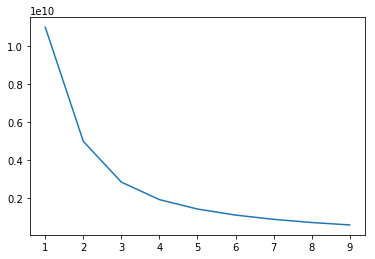

In [12]:
# K-means
from sklearn import cluster
inertia_record = []

X = by_txn
for n in range(1,10):
    k_means = cluster.KMeans(n_clusters=n)
    k_means.fit(X) 
    inertia_record.append(k_means.inertia_)

plt.plot([i for i in range(1,10)],inertia_record)


#### 2. novelty/outlier detection model

- one-class SMV
    
    > Hmm..... <br/>
    > not doing well

In [241]:
# select wanted fearture and paramater
elements_col = np.setdiff1d(train_raw.columns.values, ['cano','bacno','fraud_ind','txkey'])
label_col = 'fraud_ind'
all_col = np.append(elements_col,label_col)
sample_fraction = 50

In [221]:
from sklearn.svm import OneClassSVM
sample_data = train_raw[all_col].sample((round(N/sample_fraction)))
train_x = sample_data[elements_col]
train_y = sample_data[label_col]
train_x.replace(np.NAN, 0,inplace = True)

In [14]:
# compare model
kernel_options = ['rbf', 'sigmoid','poly']
kernel_options = [kernel_options[0]]
fun_compare = {}
for ko in kernel_options:
    clf = OneClassSVM(degree = 3, kernel=ko, gamma='auto', nu=20355/1501432).fit(train_x)
    pred = clf.predict(train_x)
    fun_compare[ko]=(pred, len(np.where(pred==1)[0]),len(np.where(pred==-1)[0]))
fun_compare

{'rbf': (array([-1, -1, -1, ...,  1,  1,  1]), 14121, 1097)}

In [78]:
def model_evl(pred, label):
    if len(pred)!=len(label):
        raise Exception('length not equal, plz chk, pred:%s, label: %s'%(len(pred), len(label)))
    evl = {}
    if sorted(np.unique(pred)) == [-1,1]:
        pred[pred==-1]=0
    a = pd.concat([pd.Series(pred, name='pred'), label.reset_index()['fraud_ind']],axis=1)
    #evl['ACC'] = sum(a['pred']==a['fraud_ind'])/len(pred) # accuracy
    evl['TP'] = sum((a['pred']==1) & (a['fraud_ind'] ==0)) # inlier & non-fraud
    evl['TN'] = sum((a['pred']==0) & (a['fraud_ind'] ==1)) # outlier & fraud
    evl['MS'] = sum((a['pred']==1) & (a['fraud_ind'] ==1)) # inlier & fraud
    evl['FA'] = sum((a['pred']==0) & (a['fraud_ind'] ==0)) # outlier & non-fraud
    evl['ACC'] = (evl['TP']+evl['TN'])/len(pred)
    return evl

def cal_f1(evl):
    precision = evl['TN']/(evl['TN']+evl['FA'])
    recall = evl['TN']/(evl['TN']+evl['MS'])
    F_1 = 2*(precision*recall/(precision+recall))
    return F_1

In [16]:
for f in kernel_options:
    evl_f = model_evl(fun_compare[f][0], train_y)
    print(f,':', evl_f)
    

NameError: name 'kernel_options' is not defined

----

- isolation forest

> better, but not good enough

In [242]:
#try isolation forest
from sklearn.ensemble import IsolationForest
error_fraction = sum(train_y)/len(train_x)
tracking=[]
for i in range(1):
    clf = IsolationForest(bootstrap=True,  max_samples=200,
                          max_features=2, contamination=error_fraction, n_estimators=500)
    clf.fit(train_x)
    pred = clf.predict(train_x)
    evl = model_evl(pred,train_y)
    F_1 = cal_f1(evl)
    print('para: %s'%i, evl ,'F1: ',F_1)
    tracking.append(pred)

para: 0 {'TP': 29713, 'TN': 75, 'MS': 324, 'FA': 324, 'ACC': 0.9787094230516493} F1:  0.18796992481203006


In [243]:
precision=evl['TN']/(evl['TN']+evl['FA'])
recall=evl['TN']/(evl['TN']+evl['MS'])
#(precision*recall)/(precision+recall)
print(recall, precision)

0.18796992481203006 0.18796992481203006


### Some ingisght :
- the novelty/outlier detection seem not work very well on fraud data

## try SVM

## Try MCA
MCA: Mutiple Correspondance Analysis

In [4]:
import json

with open("feature_map.json",encoding='utf-8') as json_data:
     f_m = json.load(json_data)

In [7]:
import pandas as pd 
import prince

exclude = ['bacno', 'txkey','locdt','loctm', 'cano','conam','mchno','acqic','scity','fraud_ind','mcc']


In [13]:
X = train_raw.drop(exclude, axis=1).replace(np.NAN, -1)

In [14]:
X.head()

,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,hcefg,insfg,iterm,ovrlt,stocn,stscd
0,5,0,0,0,0.0,0.0,5,0,0,0,102,0
1,5,0,0,2,0.0,0.0,0,0,0,0,102,0
2,5,0,0,0,0.0,0.0,5,0,0,0,102,0
3,5,62,0,5,0.0,0.0,5,0,0,0,102,0
4,5,62,0,4,0.0,0.0,5,0,0,0,102,0


In [15]:
mca = prince.MCA(n_components=12)

In [16]:
mca = mca.fit(X) 

In [17]:
mca_proj = mca.transform(X)

In [19]:
[i/sum(mca.eigenvalues_) for i in mca.eigenvalues_]

[0.15043486837596173,
 0.09931718572111556,
 0.0802905044169569,
 0.07607187837248745,
 0.07519486896401834,
 0.07446871728383699,
 0.07444327478254771,
 0.07435919253983751,
 0.07427786256556104,
 0.07393946605410591,
 0.07366439619158895,
 0.07353778473198173]

In [21]:
sum([i / sum(mca.eigenvalues_) for i in mca.eigenvalues_][0:9])

0.7788583530223232

In [22]:
print(mca_proj)

                0         1         2         3         4         5         6  \
0       -0.090854 -0.604115 -0.493843  0.313076  0.019741 -0.038789 -0.001491   
1       -0.083835 -0.571963 -0.594150  0.370798 -0.108552 -0.039860 -0.001434   
2       -0.090854 -0.604115 -0.493843  0.313076  0.019741 -0.038789 -0.001491   
3       -0.086315 -0.219788  0.099089 -0.036238  0.052625  0.014221 -0.004180   
4       -0.083417 -0.200314  0.137654 -0.061296  0.043699  0.010257  0.005327   
...           ...       ...       ...       ...       ...       ...       ...   
1521782  6.358206 -0.217117  0.044128 -0.010628 -0.002556  0.001521  0.001264   
1521783  6.358206 -0.217117  0.044128 -0.010628 -0.002556  0.001521  0.001264   
1521784  6.358206 -0.217117  0.044128 -0.010628 -0.002556  0.001521  0.001264   
1521785  6.312609 -0.457595  0.033491 -0.035582 -0.024900  0.000987 -0.006874   
1521786  6.235643 -0.907579  0.110331 -0.140395  0.037742  0.013852 -0.011776   

                7         8

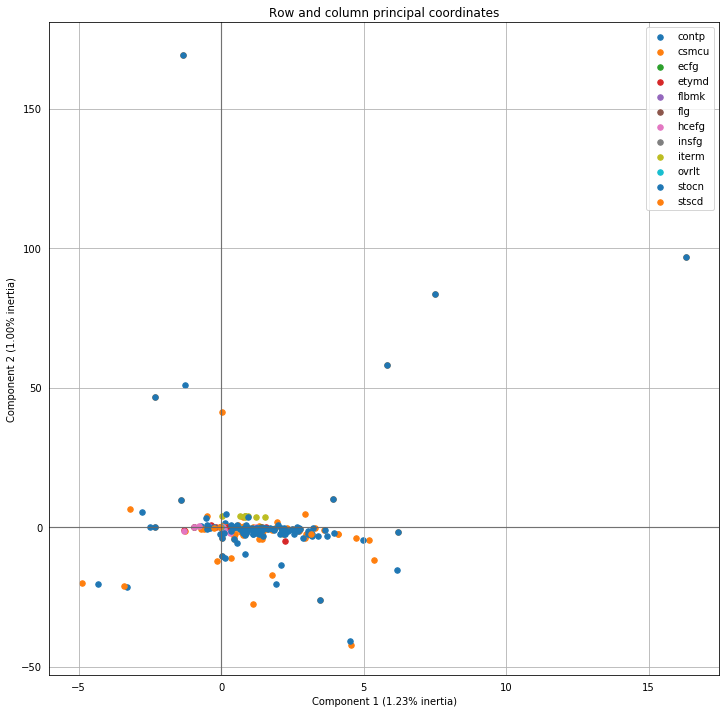

In [24]:
ax = mca.plot_coordinates(X,ax=None,figsize=(12, 12),x_component=1,y_component=2,show_row_points=False)

In [25]:
import csv
b = mca_proj
mca_proj.to_csv('train_mca_out.csv')

In [90]:
for k in f_m:
    print("%s %s:%s"%(k,f_m[k]['name'], f_m[k]["distinct"]['count']))

bacno歸戶帳號:95214
txkey交易序號:1521787
locdt授權日期:90
loctm授權時間:84810
cano交易卡號:129413
contp交易類別:7
etymd交易型態:11
mchno特店代號:89316
acqic收單行代碼:6051
mccMCC_CODE:434
conam交易金額-台幣 (經過轉換):72961
ecfg網路交易註記:2
insfg分期交易註記:2
iterm分期期數:9
stocn消費地國別:103
scity消費城市:5698
stscd狀態碼:5
ovrlt超額註記碼:2
flbmkFallback 註記:3
hcefg支付形態:9
csmcu消費地幣別:72
flg_3dsmk3DS 交易註記:3
fraud_ind盜刷註記:2


do k-means first
> mchno:89316

>  acqic:6051

>  scity:5698

>  mcc:434

In [1]:
f_m

NameError: name 'f_m' is not defined